In [1]:
!unzip -q ~/aiffel/Polyp_seg/Polyp_segmentation.zip -d ~/aiffel/Polyp_seg

|평가문항|상세기준|
|:--------:|:--------:|
|1. 모델의 성능을 정량적으로 평가하였는가?|Segmentation 모델의 성능을 IOU 기준 0.7 이상으로 달성하기|
|2. 모델이 예측한 결과물에 대해 정성적으로 분석하였는가?|모델의 출력 결과를 케이스 별로 구분하고, 특이점에 대한 관찰 결과를 정리하여 학습 전략을 도출하기|
|3. 기계 학습을 통해 문제 해결 방법론과 자원 확보 전략을 확장할 수 있는가?|Polyp 탐지에서 segmentation label 이 없거나, object detection 와 같이 낮은 차원의 label 만 있을 경우, 모델의 성능을 표현할 방법과 이에 맞는 학습 전략을 기획하여 제시하기|

In [39]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from skimage import io
from glob import glob
import cv2
# 이미지 로드
#image = io.imread('xxx.jpg')
# 이미지는 넘파이 배열로 표현됨
import matplotlib.pyplot as plt

In [40]:
from albumentations import  HorizontalFlip,VerticalFlip, Compose, Rotate, Resize, RandomBrightnessContrast
def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.3),    # 30%의 확률로 좌우대칭
                        VerticalFlip(p=0.3),# 30%의 확률로 상하대칭
                        Rotate(limit=20, p=0.3, border_mode=cv2.BORDER_REPLICATE),
                        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),#명도 채도 랜덤변환

                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224)
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                    Resize(
                    width=224,
                    height=224)
                ])
def cutmix(image1,image2, mask1, mask2):
    pass
def visual(origin_img, output):
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.3)
    return output
     
train_dir_path = os.getenv('HOME')+'/aiffel/Polyp_seg/Polyp_segmentation/train/PNG'
test_dir_path = os.getenv('HOME')+'/aiffel/Polyp_seg/Polyp_segmentation/test'
#Originals
#Ground Truth
#test/images
#labels

In [41]:
input_images = glob(os.path.join(train_dir_path, "Originals", "*.png"))
input_masks = glob(os.path.join(train_dir_path, "Ground Truth", "*.png"))

input_images.sort()
input_masks.sort()

In [42]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)

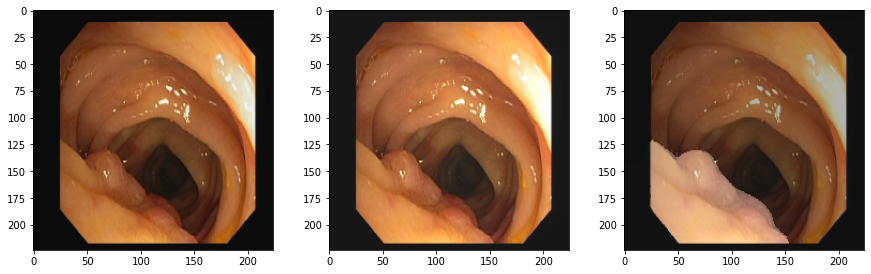

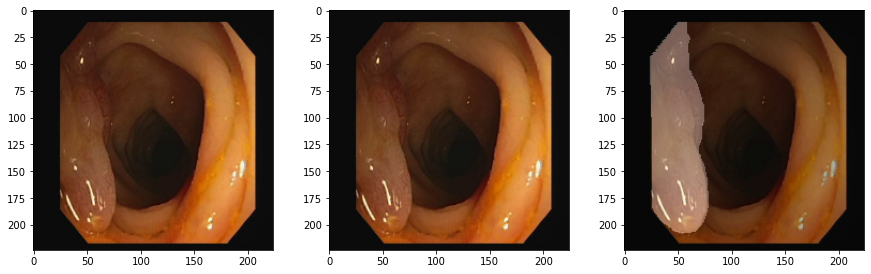

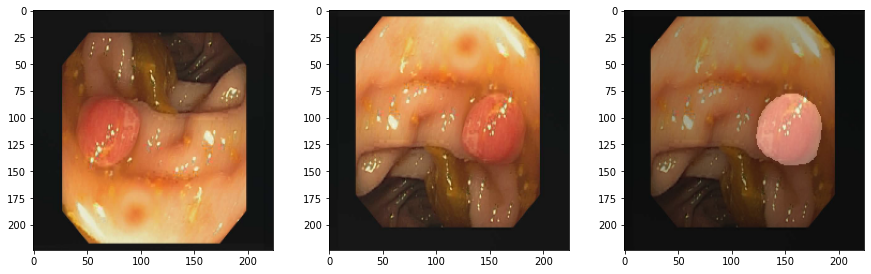

In [43]:
for i in range(3):
    image = io.imread(input_images[i]) 
    mask = io.imread(input_masks[i]) 
    image_data = {"image":image,
                  "mask": mask}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(3, 3, 3*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    plt.subplot(3, 3, 3*i+3)
    plt.imshow(visual(processed["image"], processed["mask"]))  # 왼쪽이 원본이미지
    

    
plt.show() 

In [44]:
class PolybGenerator(tf.keras.utils.Sequence):
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        if self.is_train:
            self.data_dir_name = "Originals"
            self.label_dir_name = "Ground Truth"
        else:
            self.data_dir_name = "images"
            self.label_dir_name = "labels"
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        if self.is_train:
            input_images = glob(os.path.join(self.dir_path, self.data_dir_name, "*.png"))
            label_images = glob(os.path.join(self.dir_path, self.label_dir_name, "*.png"))
        else:
            input_images = glob(os.path.join(self.dir_path, self.data_dir_name, "*.bmp"))
            label_images = glob(os.path.join(self.dir_path, self.label_dir_name, "*.bmp"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        return data
    
    def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        for i, data in enumerate(batch_data):
            
            input_img_path, output_path = data
            _input = io.imread(input_img_path)
            _output = io.imread(output_path, as_gray = True)
            
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

In [45]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = PolybGenerator(
    train_dir_path, 
    augmentation=augmentation,
)

test_generator = PolybGenerator(
    test_dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [46]:
test=train_generator[0]

ValueError: could not broadcast input array from shape (224,224,3) into shape (572,572,3)

In [ ]:
plt.imshow(test[0][0])

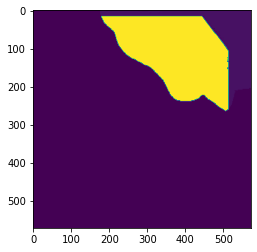

In [47]:
plt.imshow(test[1][0])

In [50]:
def encoderBox(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(inputs)#논문에서는 vaild
    skip = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    output = tf.keras.layers.MaxPooling2D(pool_size=2, strides = 2)(skip)
    
    return skip, output

def decoderBox(skip, inputs, filters):
    x = tf.keras.layers.Conv2DTranspose(filters, 2, padding='same', strides=2, activation='relu')(inputs)
    
    x = tf.keras.layers.Concatenate()([skip, x])
    x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    output = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    
    return output

def get_Unet(num_classes):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    skip1, x = encoderBox(inputs, 64)
    skip2, x = encoderBox(x, 128)
    skip3, x = encoderBox(x, 256)
    skip4, x = encoderBox(x, 512)

    x = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x)

    x = decoderBox(skip4, x, 512)
    x = decoderBox(skip3, x, 256)
    x = decoderBox(skip2, x, 128)
    x = decoderBox(skip1, x, 64)
    
    if num_classes==1:
        outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(x)
        
    else:
        outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model
    
unet_model = get_Unet(1)

In [51]:
unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_234 (Conv2D)             (None, 224, 224, 64) 1792        input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_235 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_234[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_85 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_235[0][0]                 
____________________________________________________________________________________________